## Predicting Product Prices

Selecting a model and evaluating the quantized base model against the task.

In [1]:
# pip installs - ignore the error message!

!pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece tiktoken matplotlib

In [2]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Tokenizers

LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"
QWEN_2_5 = "Qwen/Qwen2.5-7B"
GEMMA_2 = "google/gemma-2-9b"
PHI_3 = "microsoft/Phi-3-medium-4k-instruct"

# Constants

BASE_MODEL = LLAMA_3_1
HF_USER = "zoya-hammadk"
DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = False

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

In [4]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [5]:
def investigate_tokenizer(model_name):
  print("Investigating tokenizer for", model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  for number in [0, 1, 10, 100, 999, 1000]:
    tokens = tokenizer.encode(str(number), add_special_tokens=False)
    print(f"The tokens for {number}: {tokens}")

In [ ]:
investigate_tokenizer(PHI_3)

Investigating tokenizer for microsoft/Phi-3-medium-4k-instruct
The tokens for 0: [29871, 29900]
The tokens for 1: [29871, 29896]
The tokens for 10: [29871, 29896, 29900]
The tokens for 100: [29871, 29896, 29900, 29900]
The tokens for 999: [29871, 29929, 29929, 29929]
The tokens for 1000: [29871, 29896, 29900, 29900, 29900]


In [7]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [8]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nAXE HEAVEN Stranger Things Eddie's Guitar Mini Guitar Model\nIT'S TIME. Officially Licensed Stranger Things Eddie's Guitar B.C. Rich NJ Warlock Mini Guitar Model - 100% HANDCRAFTED with an amazing crackle finish just as seen in the NETFLIX Series. This collectible miniature guitar replica was hand-crafted to honor Eddie's Warlock guitar as seen in the NETFLIX Stranger Things series (and Official Trailer below). This miniature has captured all of the distinct features that the real guitar B.C. Rich Guitar has. * INCLUDES THE LIMITED EDITION STRANGER THINGS COLLECTORS SLEEVE\\nINCLUDES THE LIMITED EDITION STRANGER THINGS COLLECTORS SLEEVE\\nIndividually Handcrafted with the highest attention to detail\\n\n\nPrice is $",
 'price': 32.7}

### Prepare our Base Llama Model for evaluation

Load our base model with 8 bit quantization and try out 1 example

In [ ]:
## pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [10]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 9.1 GB


In [11]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [13]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [14]:
model_predict(test[0]['text'])

19.99

### Evaluation!

Trying out our base Llama 3.1 model against the Test dataset
Saving results to a text file

In [15]:
import datetime

In [16]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)

        safe_title = self.title.replace(" ", "_").lower()
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{safe_title}_{timestamp}.png"
        plt.savefig(filename, dpi=300)

        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"

        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        model_name = self.predictor.__name__

        log_entry = (
        f"===== {self.title} =====\n"
        f"Timestamp: {timestamp}\n"
        f"Model: {model_name}\n"
        f"Results: {title}\n\n"
        )

        with open("tester_log.txt", "a") as f:
          f.write(log_entry)

        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $19.99 Truth: $32.70 Error: $12.71 SLE: 0.22 Item: AXE HEAVEN Stranger ...
2: Guess: $7.50 Truth: $213.94 Error: $206.44 SLE: 10.43 Item: Southbend Range Natu...
3: Guess: $25.99 Truth: $79.99 Error: $54.00 SLE: 1.21 Item: SUNY Party Lights DJ...
4: Guess: $25.99 Truth: $18.99 Error: $7.00 SLE: 0.09 Item: 113PCS Birthday Part...
5: Guess: $25.00 Truth: $44.95 Error: $19.95 SLE: 0.32 Item: Artist Unknown A- B ...
6: Guess: $25.00 Truth: $84.99 Error: $59.99 SLE: 1.43 Item: PINK Child’s Practic...
7: Guess: $299.00 Truth: $592.95 Error: $293.95 SLE: 0.47 Item: PENNZONI 4ft Drum Sh...
8: Guess: $19.99 Truth: $325.01 Error: $305.02 SLE: 7.52 Item: LEGO Bionicle Umarak...
9: Guess: $25.00 Truth: $90.99 Error: $65.99 SLE: 1.60 Item: (Red) - Hape E3153 T...
10: Guess: $19.99 Truth: $52.39 Error: $32.40 SLE: 0.87 Item: LEGO DUPLO My Town B...
11: Guess: $54.99 Truth: $202.47 Error: $147.48 SLE: 1.66 Item: Aquamarine Fate/Gran...
12: Guess: $25.00 Truth: $161.58 Error: $136.58 SLE: 3.

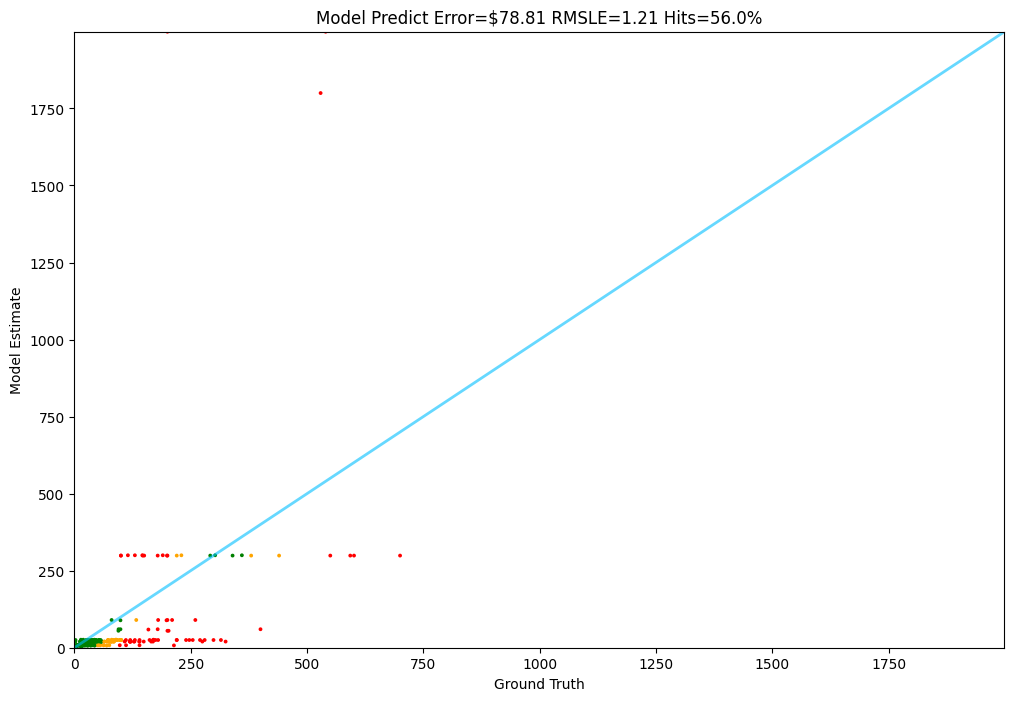

In [17]:
Tester.test(model_predict, test)